In [2]:
import sys
sys.path.append('/Users/elliottunstall/Desktop/Imperial/FYP/codebase2/utils')
import mat73
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, exposure
from skimage.util import img_as_ubyte
from segmentation_toolkit import Segmentation, Mask
import cv2

In [3]:
print("Loading data...")
images1 = mat73.loadmat('/Users/elliottunstall/Desktop/Imperial/FYP/Kidney dataset/elliot_kidney_data.mat')
# print("50%")
# images2 = mat73.loadmat('/Users/elliottunstall/Desktop/Imperial/FYP/Kidney dataset/Beamformed_Acquisition_2.mat')
print("100%")
print("Data loaded")


Loading data...
100%
Data loaded


shape: (1281, 511, 500, 2)


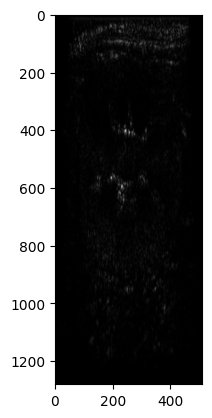

In [4]:
# print(images1.items())
print(f"shape: {np.shape(images1['ImgData'])}")
data = abs(images1['ImgData'][:,:,0,0])
normalised_data = (data - np.min(data)) / (np.max(data) - np.min(data))
plt.imshow(normalised_data, cmap='gray')

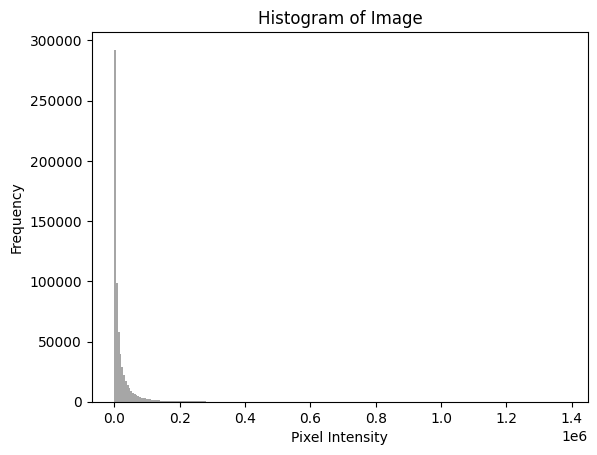

In [5]:
# Flatten the image into 1 dimension
pixels = data.flatten()

# Plot the histogram
plt.hist(pixels, bins=256, color='gray', alpha=0.7)

plt.title('Histogram of Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.show()

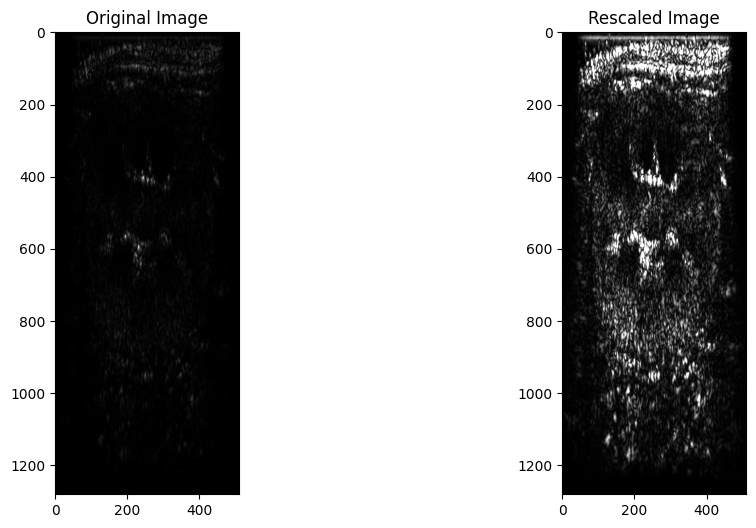

In [6]:
# Define the range of intensities you want to enhance
v_min, v_max = np.percentile(data, (2,98))

# Rescale the intensities to the range 0-1
image_rescaled = exposure.rescale_intensity(data, in_range=(v_min, v_max))

# Display the original and rescaled images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(data, cmap='gray')
ax1.set_title('Original Image')

ax2.imshow(image_rescaled, cmap='gray')
ax2.set_title('Rescaled Image')

plt.show()
# image_8bit = img_as_ubyte(image_rescaled)
# io.imsave('/Users/elliottunstall/Desktop/Imperial/FYP/Kidney dataset/frame_rescaled_001.jpg', image_8bit)

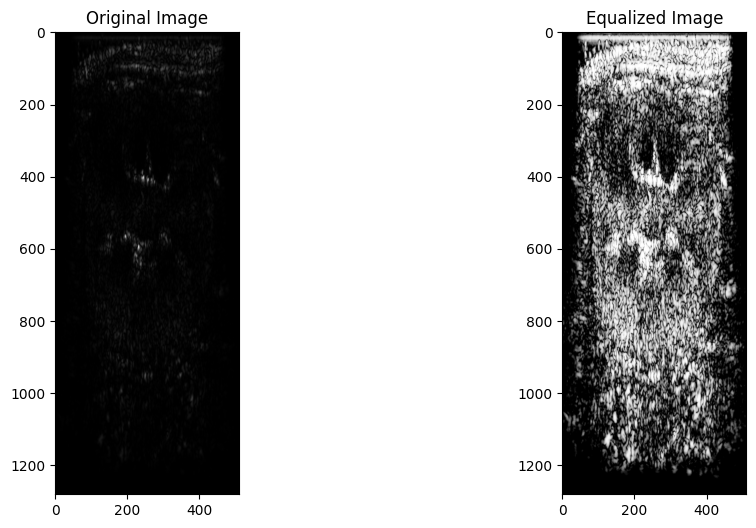

In [7]:
# Apply histogram equalization
image_eq = exposure.equalize_hist(data)

# Display the original and equalized images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(data, cmap='gray')
ax1.set_title('Original Image')

ax2.imshow(image_eq, cmap='gray')
ax2.set_title('Equalized Image')

plt.show()

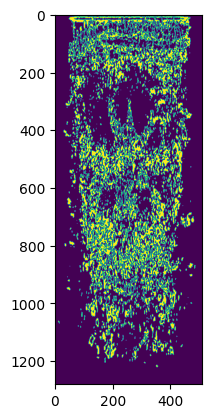

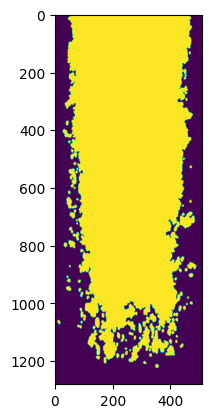

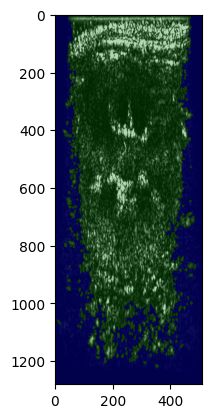

In [8]:
# Segment the fixed image
seg_fixed = Segmentation(image_rescaled, method='kmeans')
# seg_fixed.kmeans(mrf=5)
# seg_fixed.otsu_thresholding()
seg_fixed.use_regions()
# seg_fixed.apply_smoothing(method='morph_closing', kernel_size=3, shape="+", iterations=3, region='tissue')
seg_fixed.apply_smoothing(method='binary_dilation', kernel_size=3, shape="+", iterations=3, region='tissue')
seg_fixed.apply_smoothing(method='gaussian', kernel_size=5, sigma=1, region='tissue')
seg_fixed.apply_smoothing(method='fill_holes', region='tissue')
seg_fixed.normalise_background()
fixed_mask = seg_fixed.masks['tissue'][0].mask

plt.figure()
plt.imshow(seg_fixed.regions['tissue'])
plt.show()
plt.imshow(seg_fixed.masks['tissue'][0].mask)
plt.show()
seg_fixed.show(alpha=0.3)

[0. 1.]


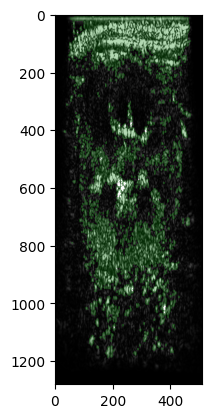

In [9]:
import cv2
import numpy as np
# Define lower and upper thresholds
lower_val = 0.3
upper_val = 0.4

# Threshold the image to create a mask
mask = cv2.inRange(image_rescaled, lower_val, upper_val)

# Convert the mask to binary
binary_mask = mask / 255

# Print unique values in the binary mask
print(np.unique(binary_mask))

plt.imshow(mask)

mask = Mask(binary_mask, None, 'tissue')
seg_fixed.masks['tissue'] = [mask]
seg_fixed.masks['background'] = []
seg_fixed.apply_smoothing(method='binary_dilation', kernel_size=3, shape="+", iterations=3, region='tissue')
seg_fixed.apply_smoothing(method='gaussian', kernel_size=5, sigma=1, region='tissue')
seg_fixed.apply_smoothing(method='fill_holes', region='tissue')

seg_fixed.show(alpha=0.3)


(1281, 511)


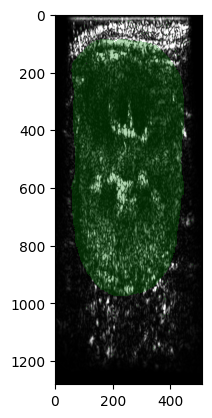

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load an image
image = cv2.imread('/Users/elliottunstall/Desktop/Imperial/FYP/Kidney dataset/frame_rescaled_001_markup.jpg')

# Convert the image from BGR to RGB
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(np.shape(image[:,:,0]))

# # Calculate the histogram for each color channel
# colors = ('r', 'g', 'b')
# for i, color in enumerate(colors):
#     histogram = cv2.calcHist([image], [i], None, [256], [0, 256])
#     plt.plot(histogram, color=color)

# # Display the plot
# plt.title('Histogram for each color channel')
# plt.xlabel('Pixel value')
# plt.ylabel('Frequency')
# plt.show()

# Define lower and upper thresholds for red color
lower_red = 130
upper_red = 135

# Threshold the image to get only red colors
mask = cv2.inRange(image[:,:,0], lower_red, upper_red)

# Bitwise-AND mask and original image
res = cv2.bitwise_and(image, image, mask=mask)

plt.imshow(mask)

# Segment the fixed image
seg_fixed = Segmentation(image_rescaled, method='kmeans')

mask = Mask(mask, None, 'tissue')
seg_fixed.masks['tissue'] = [mask]
seg_fixed.masks['background'] = []

seg_fixed.show(alpha=0.3)



In [12]:
import numpy as np
from scipy.signal import correlate2d

# Assume images is your 3D numpy array of images
# images.shape should be (num_images, height, width)

images = images1['ImgData'][:,:,:,0]

# Calculate cross-correlation between each pair of images
cross_correlations = []
for i in range(len(images)):
    for j in range(i+1, len(images)):
        cross_correlation = correlate2d(images[i], images[j]).max()
        cross_correlations.append((cross_correlation, i, j))

# Find the image that has the highest average cross-correlation with all other images
average_cross_correlations = np.zeros(len(images))
for cross_correlation, i, j in cross_correlations:
    average_cross_correlations[i] += cross_correlation
    average_cross_correlations[j] += cross_correlation
average_cross_correlations /= len(images) - 1
most_similar_image_index = np.argmax(average_cross_correlations)

print(f"The most similar image to all others is at index: {most_similar_image_index}")